In [ ]:
Zoom Tif to Just One County

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd

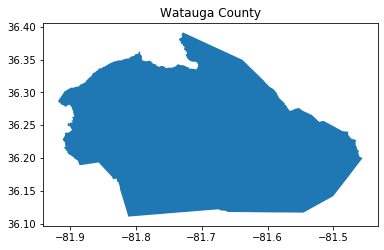

In [5]:
#Filter ShapeFile to just one county
import geopandas as gpd

# Load the shapefile
shapefile_path = "/data/HW/HW2/NCDOT_County_Boundaries.shp"
counties = gpd.read_file(shapefile_path)
gdf = counties.to_crs(epsg=4326)

filtered_gdf = gdf[gdf['CountyName'] == 'Watauga']

# Optionally, save the filtered shapefile
filtered_gdf.to_file("filtered_watauga.shp")
# View the first few rows of the data to inspect the content
filtered_gdf.plot()

# Add a title and display the plot
plt.title("Watauga County")
plt.show()

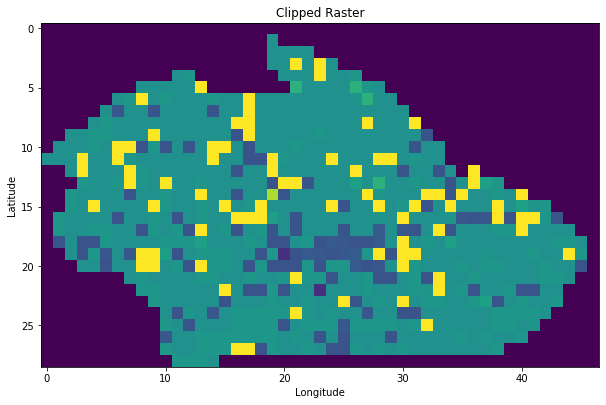

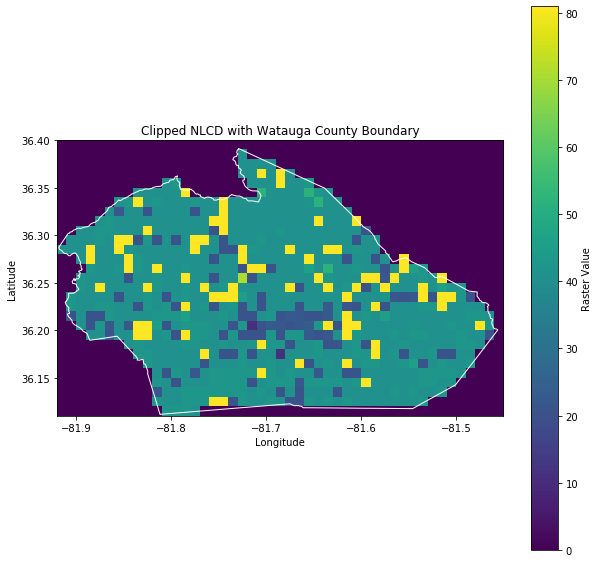

In [25]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np

# Define the value-to-name mapping
value_to_name = {
    11: "Open Water",
    12: "Perennial Ice / Snow",
    21: "Developed Open Space",
    22: "Developed Low Intensity",
    23: "Developed Medium Intensity",
    24: "Developed High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    51: "Dwarf Scrub",
    52: "Shrub",
    71: "Grasslands",
    73: "Lichens",
    74: "Moss",
    81: "Pasture Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Herbaceous Wetlands"
}

# Load the shapefile
shapefile = gpd.read_file('filtered_watauga.shp')

# Ensure the shapefile's CRS is WGS84 (latitude/longitude)
shapefile = shapefile.to_crs(epsg=4326)

# Load the raster file
raster_path = '/shared_space/ACV/nlcd_nc0.1.tif'
raster = rasterio.open(raster_path)

# Get the geometry from the shapefile
shapefile_geometry = shapefile.geometry

# Convert the geometry to the appropriate format for masking
geometry = [feature.__geo_interface__ for feature in shapefile_geometry]

# Mask the raster using the shapefile geometry
out_image, out_transform = mask(raster, geometry, crop=True)

# Update metadata
out_meta = raster.meta
out_meta.update({
    "driver": "GTiff",
    "count": 1,
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Map the raster values to their labels
labeled_image = np.copy(out_image[0])  # Copy the image data for labeling

# Apply the mapping: replace numeric values with their corresponding labels
labeled_image = np.vectorize(value_to_name.get)(labeled_image)

# Save the labeled raster as a new GeoTIFF (optional)
clipped_labeled_raster_path = '/shared_space/ACV/clipped_labeled_nlcd_nc0.1.tif'
with rasterio.open(clipped_labeled_raster_path, 'w', **out_meta) as dest:
    # We will write the original image (numeric values) to the file,
    # since the labels are categorical (strings), we can't write them directly to raster.
    dest.write(out_image)

# Plot the labeled raster (now using a color map)
fig, ax = plt.subplots(figsize=(10, 10))

# Show the original numeric raster (since we can't plot strings directly)
cax = ax.imshow(out_image[0], cmap='viridis', extent=(
    out_transform[2],  # left (min longitude)
    out_transform[2] + out_transform[0] * out_image.shape[2],  # right (max longitude)
    out_transform[5] + out_transform[4] * out_image.shape[1],  # bottom (min latitude)
    out_transform[5]  # top (max latitude)
))

# Add a colorbar (legend) for the raster values
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Raster Value')

# Plot the shapefile boundaries on top of the raster
shapefile.plot(ax=ax, facecolor='none', edgecolor='white')

# Set plot title and labels
ax.set_title("Clipped NLCD with Watauga County Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()



In [2]:
import rasterio

# Path to the TIFF file
file_path = "/shared_space/ACV/clipped_labeled_nlcd_nc0.1.tif"

# Open the TIFF file using rasterio
with rasterio.open(file_path) as src:
    resolution = src.res  # (pixel_width, pixel_height)
    print(f"Resolution (pixel size): {resolution}")

Resolution (pixel size): (0.01, 0.01)


In [3]:
import numpy as np

# Given resolution in degrees
pixel_width_deg = 0.01
pixel_height_deg = 0.01

# Latitude (in degrees) for the calculation
latitude = 35.0  

# Constants
meters_per_degree_lat = 111320  # Approx. meters per degree latitude
meters_per_degree_lon = meters_per_degree_lat * np.cos(np.radians(latitude))

# Convert degrees to meters
pixel_width_m = pixel_width_deg * meters_per_degree_lon
pixel_height_m = pixel_height_deg * meters_per_degree_lat

# Calculate area
area = pixel_width_m * pixel_height_m
print(f"Pixel Width: {pixel_width_m:.2f} m")
print(f"Pixel Height: {pixel_height_m:.2f} m")
print(f"Pixel Area: {area:.2f} m²")


Pixel Width: 911.88 m
Pixel Height: 1113.20 m
Pixel Area: 1015104.88 m²


In [16]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask

# Load the TIFF file
tif_file = '/shared_space/ACV/inter_files/output_file.tif'
with rasterio.open(tif_file) as src:
    # Load the shapefile
    shapefile = gpd.read_file('filtered_watauga.shp')

    # Extract geometries from the shapefile
    geometries = shapefile.geometry.values  # List of polygons

    # Clip the raster using the shapefile geometries
    out_image, out_transform = mask(src, geometries, crop=True)

    # Update metadata for the clipped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the clipped raster
clipped_tif = 'clipped_output_file.tif'
with rasterio.open(clipped_tif, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped raster saved to {clipped_tif}")



Clipped raster saved to clipped_output_file.tif


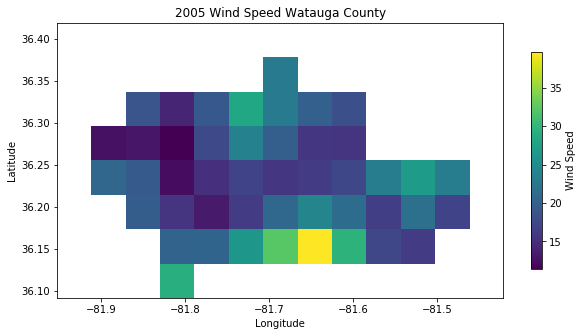

In [20]:
# Load and plot the clipped raster
with rasterio.open(clipped_tif) as clipped_src:
    clipped_data = clipped_src.read(1)
    clipped_extent = [
        clipped_src.transform[2],
        clipped_src.transform[2] + clipped_src.transform[0] * clipped_src.width,
        clipped_src.transform[5] + clipped_src.transform[4] * clipped_src.height,
        clipped_src.transform[5],
    ]

    # Plot the clipped raster
    fig, ax = plt.subplots(figsize=(10, 8))
    img = ax.imshow(clipped_data, extent=clipped_extent, cmap='viridis', origin='upper')
    cbar = plt.colorbar(img, ax=ax, label='Wind Speed', shrink=0.5, aspect=20)


    # Add titles and labels
    ax.set_title("2005 Wind Speed Watauga County")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.show()


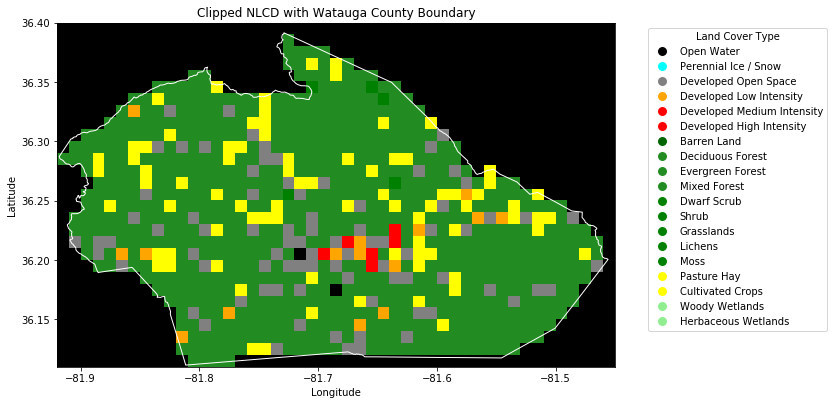

In [30]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm

# Define the value-to-name mapping
value_to_name = {
    11: "Open Water",
    12: "Perennial Ice / Snow",
    21: "Developed Open Space",
    22: "Developed Low Intensity",
    23: "Developed Medium Intensity",
    24: "Developed High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    51: "Dwarf Scrub",
    52: "Shrub",
    71: "Grasslands",
    73: "Lichens",
    74: "Moss",
    81: "Pasture Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Herbaceous Wetlands"
}

# Custom color map
colors = [
    'black', 'cyan', 'grey', 'orange', 'red', 'red', 'darkgreen',
    'forestgreen', 'forestgreen', 'forestgreen', 'green', 'green', 'green',
    'green', 'green', 'yellow', 'yellow', 'lightgreen','lightgreen'
]

# Load the shapefile
shapefile = gpd.read_file('filtered_watauga.shp')

# Ensure the shapefile's CRS is WGS84 (latitude/longitude)
shapefile = shapefile.to_crs(epsg=4326)

# Load the raster file
raster_path = '/shared_space/ACV/nlcd_nc0.1.tif'
raster = rasterio.open(raster_path)

# Get the geometry from the shapefile
shapefile_geometry = shapefile.geometry

# Convert the geometry to the appropriate format for masking
geometry = [feature.__geo_interface__ for feature in shapefile_geometry]

# Mask the raster using the shapefile geometry
out_image, out_transform = mask(raster, geometry, crop=True)

# Update metadata
out_meta = raster.meta
out_meta.update({
    "driver": "GTiff",
    "count": 1,
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Convert the raster values into discrete categories
discrete_image = np.copy(out_image[0])  # Copy the image data for discrete labeling

# Apply the mapping: replace numeric values with their corresponding discrete category
categories = np.vectorize(value_to_name.get)(discrete_image)

# Create a custom colormap based on the provided list of colors
cmap = mcolors.ListedColormap(colors)

# Create a norm for the colormap to scale the values to the correct range
bounds = list(value_to_name.keys())  # Use the dictionary keys as bounds
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the raster with the discrete categories
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the discrete image using the custom colormap
cax = ax.imshow(discrete_image, cmap=cmap, norm=norm, extent=(
    out_transform[2],  # left (min longitude)
    out_transform[2] + out_transform[0] * out_image.shape[2],  # right (max longitude)
    out_transform[5] + out_transform[4] * out_image.shape[1],  # bottom (min latitude)
    out_transform[5]  # top (max latitude)
))

# Plot the shapefile boundaries on top of the raster
shapefile.plot(ax=ax, facecolor='none', edgecolor='white')

# Set plot title and labels
ax.set_title("Clipped NLCD with Watauga County Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create a custom legend for the categories
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(value_to_name))]
labels = [value_to_name[val] for val in value_to_name]

# Add the legend to the plot
ax.legend(handles=handles, labels=labels, title="Land Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

